![](https://drive.google.com/uc?export=view&id=1hq9LNXATnX2hbdoXlZJ2wgNntunYVeSN)

---

####<h2><center>**PIA: Entrenamiento de una Red Neuronal Convolusional**</center></h2>


---


**<h4><center>Matería:** Inteligencia Artificial y Redes Neuronales, Martes **Hora** N4 
**Docente:** Jesús Daniel Isaías López Páez
##### **<h4>Integrantes del equipo:**             
Luis Enrique Palacios Nacianceno **Matrícula:** 1615458

Cindy Jannet González Leal        **Matrícula:**1723100 

Luis Pablo Escobedo Tamez         **Matrícula:**1742422  

Carlos Arturo Torres Cisneros    **Matrícula:**      1793880

Ana Camila Ramirez García        **Matrícula:**       1801940</center>

###**<center>Semestre Agosto Diciembre 2021**</center>
<center>Fecha de entrega: 21 de Noviembre 2021</center>

Source [AgniData](https://colab.research.google.com/github/stephenleo/keras-model-selection/blob/main/keras_model_selection.ipynb): 
#**MODELO 1**🎴


---



##Importamos las librerias de Keras, Tensorflow y los Modulos que usaremos

In [ ]:
#Librerias
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm
#Inicializamos el valor de analisis de batch
batch_size = 100

###Visualizamos los modelos preestablecidos de alta precisión que estan disponibles, en este caso que utilizaremos: [*DenseNet*](https://github.com/flyyufelix/DenseNet-Keras)

In [ ]:
||||||# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
new_model_dictionary={'DenseNet201':model_dictionary.get('DenseNet201')}
print(new_model_dictionary)

{'DenseNet201': <function DenseNet201 at 0x7f55c1a7fef0>}


###Cargamos el dataset y previsualizamos las caracteristicas por las que esta compuesta, reducimos el tamaño del set a un 70%

In [ ]:
# Download the training and validation data
(train, validation), metadata = tfds.load('cifar100', split=['train[:70%]', 'train[70%:]'], 
                                          with_info=True, as_supervised=True)

# Number of training examples and labels
num_train = len(list(train))
num_validation = len(list(validation))
num_classes = len(metadata.features['label'].names)
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteLGOURB/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteLGOURB/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.
Num train images: 35000         
Num validation images: 15000         
Num classes: 100         
Num iterations per epoch: 350


###Pre-procesamos las imagenes para un mejor entrenamiento

In [ ]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    train_processed = train_processed.batch(batch_size).repeat()

    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    validation_processed = validation_processed.batch(batch_size)

    return train_processed, validation_processed

# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train, validation, batch_size, img_size=[331,331])

###Preparamos el entrenamiento, con los diferentes modelos prestablecidos

In [ ]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(new_model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=10, validation_data=validation_processed, 
                            steps_per_epoch=num_iterations)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/1 [00:00<?, ?it/s]

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/10
350/350 [==============================] - 465s 1s/step - loss: 2.1815 - accuracy: 0.4697 - val_loss: 1.5418 - val_accuracy: 0.5911
Epoch 2/10
350/350 [==============================] - 416s 1s/step - loss: 1.3617 - accuracy: 0.6309 - val_loss: 1.3574 - val_accuracy: 0.6265
Epoch 3/10
350/350 [==============================] - 416s 1s/step - loss: 1.1781 - accuracy: 0.6729 - val_loss: 1.2909 - val_accuracy: 0.6420
Epoch 4/10
350/350 [==============================] - 413s 1s/step - loss: 1.0708 - accuracy: 0.7004 - val_loss: 1.2594 - val_accuracy: 0.6517
Epoch 5/10
350/350 [==============================] - 413s 1s/step - loss: 0.9943 - accuracy: 0.7225 - val_loss: 1.2440 - val_accuracy: 0.6561
Epoch 6/10
350/350 [==============================] - 413s 1s/step - loss: 0.9348 - accuracy: 0.7402 - val_loss: 1.2374 - val_accuracy: 0.6587
Epoch 7/10
350/350 [==============================] - 414s 1s/step - loss: 0.

100%|██████████| 1/1 [1:10:42<00:00, 4242.64s/it]


###Graficación de resultados

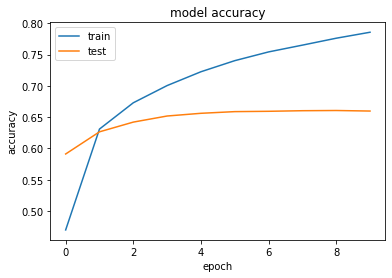

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

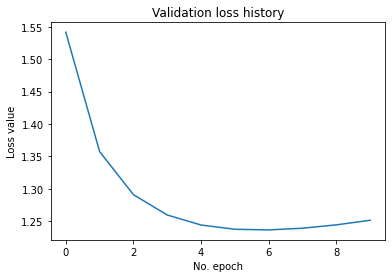

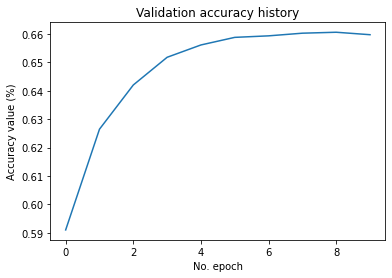

In [ ]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()